<a href="https://colab.research.google.com/github/TUIlmenauAMS/Videocoding/blob/main/imageVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Variational Autoencoder for Images

This demonstrates the principle of a neural network image coder. The latent space with the "reparameterization trick" represents the coded domain including quantization noise.

This script defines a VAE with a simple feed-forward neural network architecture. It includes functions for training and testing the VAE on the MNIST dataset. The model is trained for 20 epochs, but you can adjust the num_epochs variable to train for a different number of epochs.

Key components:

- **Encoder**: Maps input to a latent space.
- **Reparameterization Trick**: Samples from the latent space.
- **Decoder**: Maps samples from the latent space back to the input space.
- **Loss Function**: Combines reconstruction loss and KL divergence.

In [1]:
#ChatGPT:
#Write a Python program which implements a variational autoencoder for images, with Pytorch.
#Can you also make a "requirements" file?
!pip install torch==2.0.1
!pip install torchvision==0.15.2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 10 #20
latent_dim = 20  # Dimension of the latent space

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean of the latent variables
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance of the latent variables
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))  # First layer with ReLU activation
        return self.fc21(h1), self.fc22(h1)  # Return mean and log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return mu + eps*std  # Reparameterize to obtain the latent variable z

    def decode(self, z):
        h3 = F.relu(self.fc3(z))  # Decode first layer with ReLU activation
        return torch.sigmoid(self.fc4(h3))  # Decode second layer with sigmoid activation to get output

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))  # Flatten the input image and encode
        z = self.reparameterize(mu, logvar)  # Reparameterize to get z
        return self.decode(z), mu, logvar  # Decode z and return output with mu and logvar

# Loss function combining reconstruction loss and KL divergence
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD  # Total loss

# Training the model
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients
        recon_batch, mu, logvar = model(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, logvar)  # Compute loss
        loss.backward()  # Backward pass
        train_loss += loss.item()
        optimizer.step()  # Update weights
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item()/len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss/len(train_loader.dataset):.4f}')

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

for epoch in range(1, num_epochs + 1):
    train(epoch)
    test(epoch)





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

100%|██████████| 9912422/9912422 [00:00<00:00, 137009185.12it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 40405501.61it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 27565103.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4101297.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 542.691467
Train Epoch: 1 [12800/60000 (21%)]	Loss: -18996.720703
Train Epoch: 1 [25600/60000 (43%)]	Loss: -21186.136719
Train Epoch: 1 [38400/60000 (64%)]	Loss: -24723.417969
Train Epoch: 1 [51200/60000 (85%)]	Loss: -27693.357422
====> Epoch: 1 Average loss: -22051.1017
====> Test set loss: -26040.3456
Train Epoch: 2 [0/60000 (0%)]	Loss: -26168.832031
Train Epoch: 2 [12800/60000 (21%)]	Loss: -28875.382812
Train Epoch: 2 [25600/60000 (43%)]	Loss: -33095.562500
Train Epoch: 2 [38400/60000 (64%)]	Loss: -34187.601562
Train Epoch: 2 [51200/60000 (85%)]	Loss: -36657.523438
====> Epoch: 2 Average loss: -33063.9536
====> Test set loss: -38151.4614
Train Epoch: 3 [0/60000 (0%)]	Loss: -37910.722656
Train Epoch: 3 [12800/60000 (21%)]	Loss: -37934.847656
Train Epoch: 3 [25600/60000 (43%)]	Loss: -39698.097656
Train Epoch: 3 [38400/60000 (64%)]	Loss: -41424.628906
Train Epoch: 3 [51200/600

### Explanation:
1. **Hyperparameters**: Defined at the beginning for easy adjustment.
2. **Data Loading**: MNIST dataset is loaded and preprocessed.
3. **VAE Model**:
   - `__init__()`: Initializes encoder and decoder layers.
   - `encode()`: Encodes the input into mean and log variance.
   - `reparameterize()`: Reparameterization trick to sample from latent space.
   - `decode()`: Decodes the latent variable back to the input space.
   - `forward()`: Combines encode, reparameterize, and decode steps.
4. **Loss Function**: Combines reconstruction loss (BCE) and KL divergence (KLD).
5. **Training and Testing**:
   - `train()`: Trains the model for one epoch.
   - `test()`: Evaluates the model on the test dataset.
6. **Additional Function**:
   - `display_and_test_random_image()`:
     - Displays an original image.
     - Encodes it and estimates the resulting bitrate.
     - Decodes it back to an image.
     - Displays and saves the decoded image.

This version includes detailed comments to help you understand each step of the process.

## Viewing the Result

Estimated bitrate of the encoded latent space: -15.9226 bits


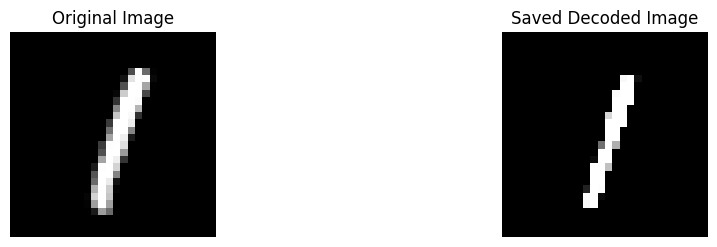

In [8]:
#ChatGPT:
#Can you also append a test, where a random image is displayed and encoded, the entropy of the encoded latent space is
#computed and displayed, and then the decoded image is stored and displayed?

import numpy as np
import matplotlib.pyplot as plt

# Additional function to display a random image, encode it, compute the bitrate, decode it, and store/display the result
def display_and_test_random_image():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))  # Get a batch of test data
        data = data[np.random.randint(0,9)].unsqueeze(0)  # Take the first image in the batch and add batch dimension
        plt.figure(figsize=(9, 3))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(data[0].view(28, 28).cpu(), cmap='gray')
        plt.axis('off')

        # Encode and compute bitrate
        mu, logvar = model.encode(data.view(-1, 28*28))
        std = torch.exp(0.5*logvar)
        var = std.pow(2)
        # Estimation of the resulting bitrate
        bitrate = torch.sum(0.5 * torch.log2(2 * np.pi * np.e * var)).item()

        print(f"Estimated bitrate of the encoded latent space: {bitrate:.4f} bits")

        # Decode the latent representation
        z = model.reparameterize(mu, logvar)
        decoded_img = model.decode(z).view(28, 28)

        # Decoded Image
        """
        plt.subplot(1, 3, 2)
        plt.title("Decoded Image")
        plt.imshow(decoded_img.cpu(), cmap='gray')
        plt.axis('off')
        """

        # Save decoded image
        plt.subplot(1, 3, 3)
        plt.title("Saved Decoded Image")
        plt.imshow(decoded_img.cpu(), cmap='gray')
        plt.axis('off')
        plt.savefig("decoded_image.png")

        plt.show()

# Call the test function to display and test a random image
display_and_test_random_image()